### Install packages

Load seq file with Carter's SeqIO python package

**Install the latest SeqIO version from github**

!pip install -e git+https://github.com/CSSFrancis/SeqIO.git#egg=seq-io&subdirectory=SeqIO/utils

this will create the souce code at /srv/home/jwei74/src by pip

move the folder in /srv/home/jwei74/anaconda3/lib/python3.7/site-packages/ and move the SeqIO subfolder out

In [3]:
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(cores=1,
                       memory ='100GB',
                       walltime="12:00:00")

/srv/home/jwei74/anaconda3/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38773 instead
  warnings.warn(


In [4]:
# Call at head node, otherwise you won't get the dashboard
from dask.distributed import Client
cluster.scale(1) # number of nodes you request
client = Client(cluster)
client

Client Scheduler: tcp://128.104.200.53:33387 Dashboard: http://128.104.200.53:38773/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [1]:
import time
import SeqIO
from SeqIO import load_folder
from SeqIO import load_celeritas
from SeqIO.version import __version__
from SeqIO.CeleritasSeqReader import SeqReader
from SeqIO.utils.file_utils import read_ref

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.io
import time
import glob,os
from scipy import optimize
from skimage import feature
from pylab import *
import math
import sys
import hyperspy.api as hs
from hyperspy import io_plugins
from PIL import Image


from tqdm.notebook import tqdm, trange
import time

### 1. Data clean up: frame number, crop, background removal

**Fix frame number**

Movie68 actually contains 65682 frames (256*256 + 146).

We want to discard the first 256 frames and the last 146 frames. 

By using nav_shape=(256,257), it add some blank frames at the end. So for further processing, we cut the first and the last row and get data in shape (256, 255)

I will try to make this less complicated for the next dataset I pass to you. 


In [4]:
signal = load_folder('/srv/home/voyles/Jingrui/Data/OurData/',lazy=True, chunk_shape=(128,128), nav_shape=(257,256))

In [5]:
signal.data

dask.array<get_image_chunk, shape=(257, 256, 128, 256), dtype=float32, chunksize=(128, 128, 128, 256), chunktype=numpy.ndarray>

In [6]:
# load into memory
signal.compute()

[########################################] | 100% Completed | 15.5s


In [7]:
# cut unwanted frames
wholedata = signal.data[1:256,:,:,:]
print(wholedata.shape)

(255, 256, 128, 256)


<IPython.core.display.Javascript object>


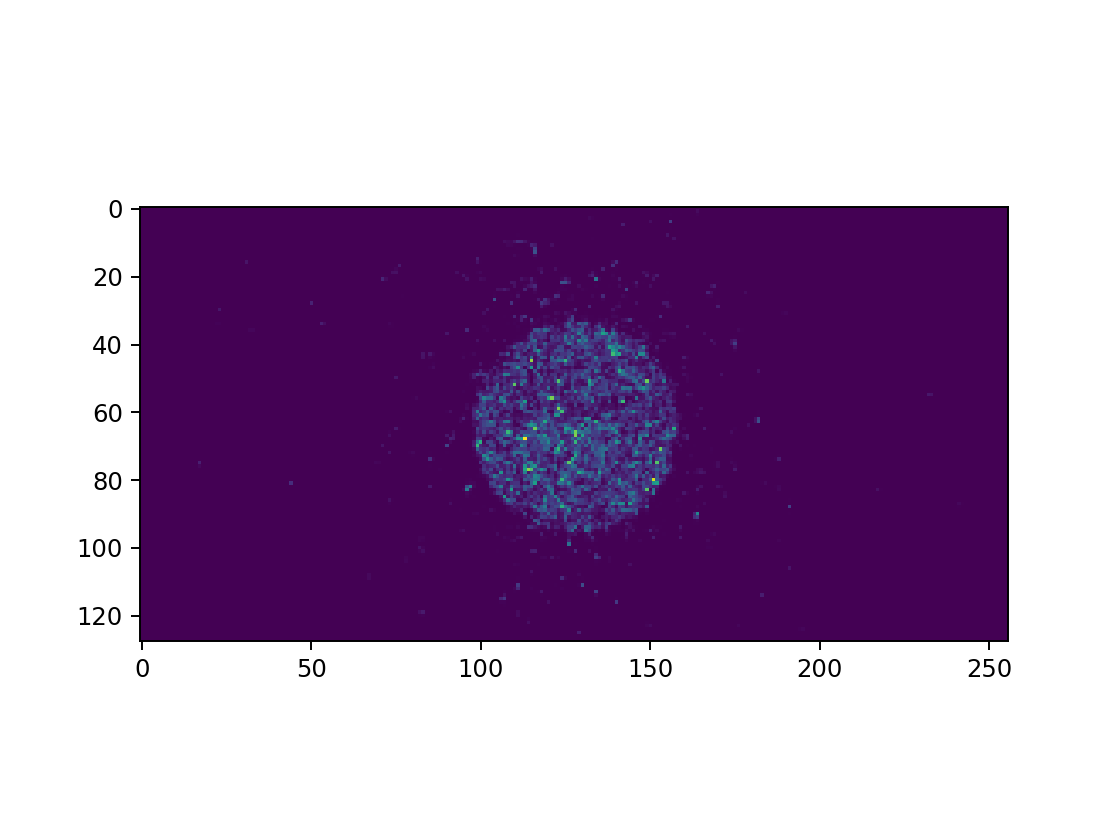

In [106]:
# take a look at a single frame
# log may help see better 
plt.figure()
plt.imshow(wholedata[254,255,:,:])
plt.show()


<IPython.core.display.Javascript object>


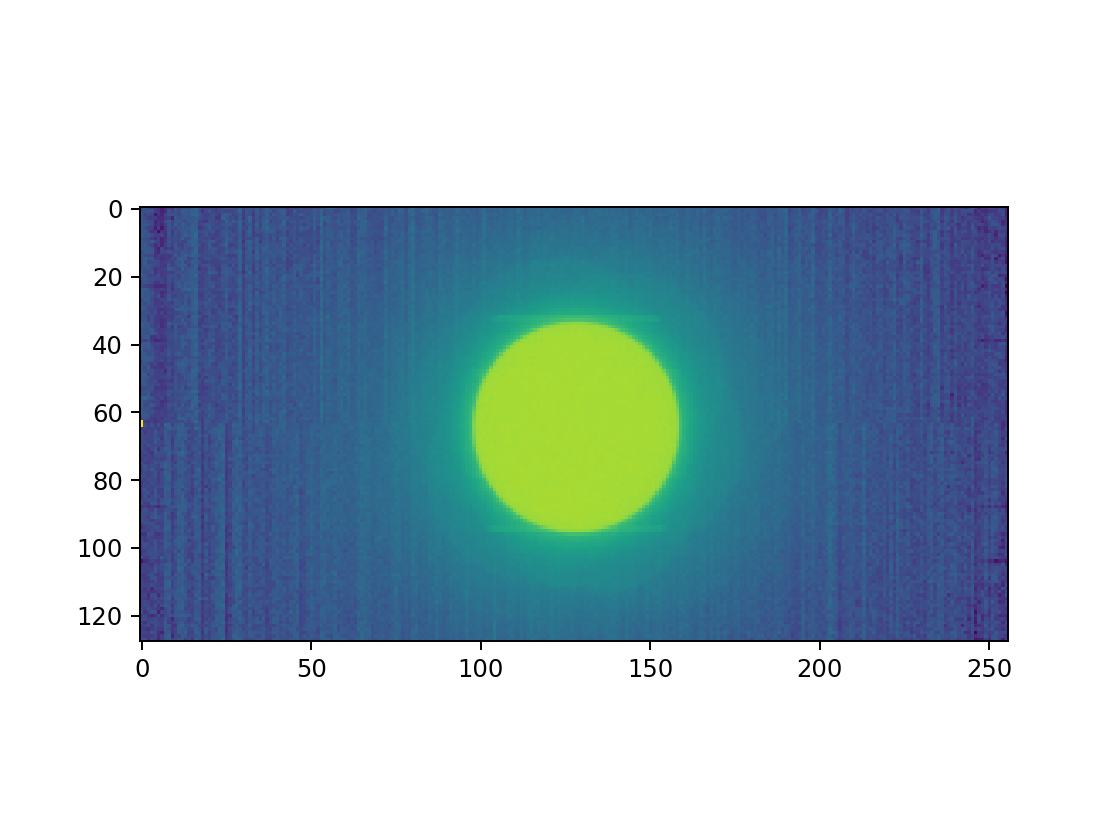

In [107]:
# take a look at the sumed PACBED
pacbed = np.sum(wholedata,axis = (0,1))
plt.figure()
plt.imshow(log(pacbed))
plt.show()

The background has some strips. There should be something wrong with the Dark ref and Gain ref. I will pay attention to it in next experiment.  

<IPython.core.display.Javascript object>


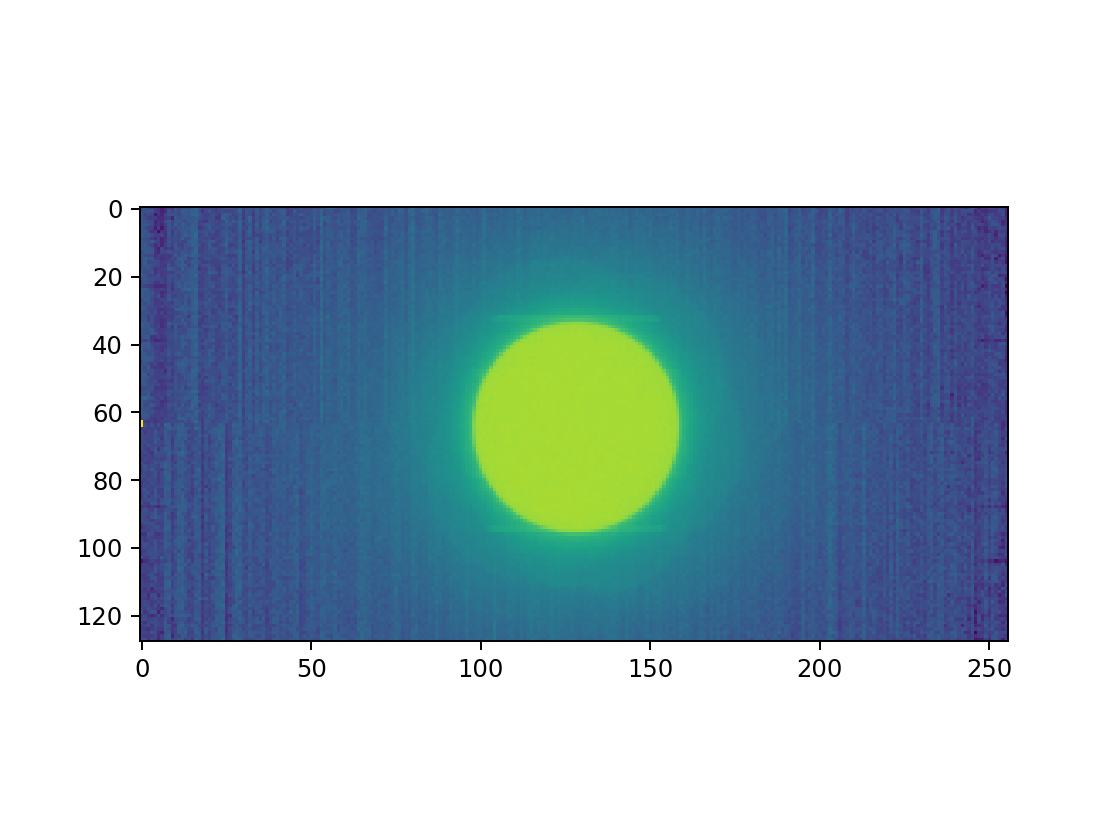

In [113]:
# apply threshold filter to get rid of noise
# let's try threshold = 5
wholedata[wholedata<5] = 0
plt.figure()
plt.imshow(log(pacbed))
plt.show()

In [110]:
#calculate the center of mass of each frame
COM = findcom(wholedata)

In [111]:
avgCOMX = np.sum(COM[:,:,0],axis = (0,1))/ COM.shape[0] /  COM.shape[1]
avgCOMY = np.sum(COM[:,:,1],axis = (0,1))/ COM.shape[0] /  COM.shape[1]
cropdata = wholedata[:, :, :,(int(avgCOMY)-64):(int(avgCOMY)+64)]
cropdata.shape

(255, 256, 128, 128)

In [117]:
sqrt((avgCOMX-142)**2+(avgCOMY-46)**2)*0.03242228573

0.7596551382382605

In [118]:
1/0.7596551382382605

1.3163868045691505

### 2. electron counting

Several types of electron counting that we might use.<br /> 
**a. linear mode:** <br /> 
after threshold filtering, just divide the data by the ADU of single eletron => **266**<br /> 
**b. counting mode:** <br /> 
apply a counting filter on the data<br />
**c. hybrid mode:** <br /> 
use linear mode in bright field area and use counting mode in other area. The frameprocessor from DE would help us do this. 


To determine if the data is sparse enough for counting mode:
only 5% of the pixels in the interested area is stroked by eletron, i.e. intensity larger than noise level.

## Aux function

In [109]:
def findcom(data):

    if len(data.shape)!= 4:
        print('Please use 4D data')
        return
    kx, ky = data.shape[2:]
    kx = np.linspace(0,kx-1,kx)
    ky = np.linspace(0,ky-1,ky)
    weights_x, weights_y = np.meshgrid(ky,kx)

    COM = np.zeros((data.shape[0],data.shape[1],2))
   
    for irow in tqdm(range(data.shape[0])):
        for icol in range(data.shape[1]):
            sample = data[irow, icol, :,:]
            COM[irow,icol,0] = np.average(weights_x,weights = sample)
            COM[irow,icol,1] = np.average(weights_y,weights = sample)
    time.sleep(0.01)
        
    return COM